### Minimum Observations

In this simplest example, let's say you have a target consisting of a planetary system around a single cool, active dwarf. For this example, we'll use AU Mic. Let's say that, given an observing strategy of once per night, we want to know how many observations we would need to achieve a threshold uncertainty on the radial velocity semi-amplitude, K, of 10%. For AU Mic, with a K of 8.5 m/s (Klein+ 2021), that means we want the minimum observations needed to reach an uncertainty of 58 cm/s. 

We'll start with the single planet case with a circular orbit and then generalize to include both AU Mic b and c. 

In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import pandas as pd
import random
import astropy 
import tinygp
from tinygp import kernels, GaussianProcess
from numpy.linalg import inv, det, solve, cond
from tqdm import tqdm
from astropy.time import Time

import matplotlib.pyplot as plt
import matplotlib

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
#from jax import random

from gaspery import calculate_fi, strategies, utils


1.23.4
1.9.3


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

path = '/Users/chris/Desktop/gaspery/'

#### White noise case

In [24]:
### target parameters
p = 8.46 # orbital period, days
K = 8.5 # m/s
T0 = 2458651.993 # central transit time, in BJD, on 19 June 2019

### white/photon noise
sigma_wn_rv = 5. # [m/s]

### choose start time as date of this writing
start = '2023-03-01T10:00:00'
start = Time(start, format='isot', scale='utc').jd

We begin by declaring our target planet's orbital parameters. Our covariance matrix in the white noise regime is simply a diagonal matrix of the photon noise. In their modeling of AU Mic b, Klein+ 2021 estimated that noise to be 5 m/s. 

We must also choose an observing cadence. The base case here is an observation once per day, for a cadence (time between observations) of 1 day.

In [184]:
cadence = 1 # observing cadence of once per day

Okay! The only thing we've left unconstrained is the number of observations. We can vary them, building an increasingly longer time series of observations, each time recalculating the covariance matrix, Fisher Information, and uncertainty on the RV semi-amplitude.

In [243]:
random = np.random.default_rng(seed=42)

sigma_ks = []
sigma_ks_stable = []
sigma_ks_solve = []
for i in tqdm(range(100)):
    # randomize start date/time, so that we are not subject to accidentally falling on an uninformative phase
    start_random = random.uniform(start, start+p) 
    
    sigma_ks_temp = []
    for n_obs in range(60)[4:]:

        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start_random, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(cadence)

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat) # object-oriented with custom kernels
        #sigma += 1e-6 

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)
        #sigma_k, sigma_k_stable, sigma_k_solve, _ = calculate(strat, theta, sigma_val=5.)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]
        sigma_ks_temp.append(sigma_k)

    sigma_ks.append(sigma_ks_temp)

  0%|                                                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2954/3006580373.py:47: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.95it/s]


In [124]:
### Cloutier+ 2018 Eqn 7 formulation
sigmas = []
for s in np.arange(len(strat[4:]))+4:
    strat_sub = strat[:s]
    
    B = 0
    for t in strat_sub:
        nu = (2*np.pi/p) * (t - T0)
        B += (np.sin(nu))**2
    B = B/sigma_wn_rv**2
    
    sigmas.append(np.sqrt(1/B))

In [219]:
random = np.random.default_rng(seed=42)

### Cloutier+ 2018 Eqn 7 formulation, random uniform sampling
sigmas_uniform = []
strat_subs = []
for s in np.arange(len(strat[4:]))+4:
    sigmas_uniform_i = []
    strat_subs_i = []
    for i in range(100):
        strat_sub = random.uniform(strat[0], strat[s], len(strat[:s]))

        B = 0
        for t in strat_sub:
            nu = (2*np.pi/p) * (t - T0)
            B += (np.sin(nu))**2
        B = B/sigma_wn_rv**2
        sigma_uniform_i = np.sqrt(1/B)
        sigmas_uniform_i.append(sigma_uniform_i)
        strat_subs_i.append(strat_sub)
        
    sigmas_uniform.append(np.mean(sigmas_uniform_i))
    strat_subs.append(strat_subs_i)

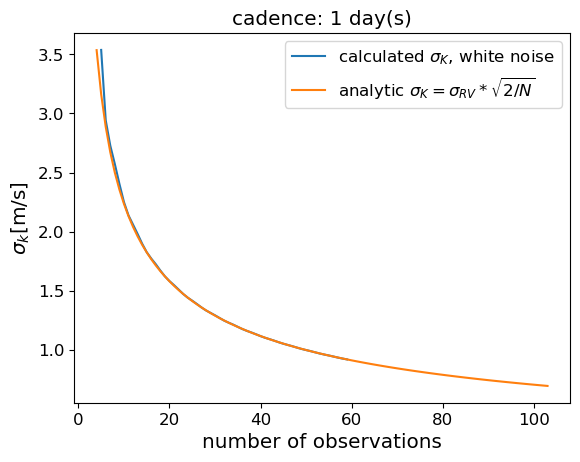

In [244]:
plt.plot(np.arange(len(sigma_ks[0]))+4, np.mean(sigma_ks, axis=0), label='calculated $\sigma_K$, white noise')
#plt.plot(np.arange(len(sigma_ks_stable))+5, np.array(sigma_ks_stable), label='calculated $\sigma_{K, stable}$, white noise')
#plt.plot(np.arange(len(sigma_ks_solve))+5, np.array(sigma_ks_solve), label='calculated $\sigma_{K, solve}$, white noise')

plt.plot(np.arange(len(sigma_ks))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks))+4)), label='analytic $\sigma_K = \sigma_{RV}*\sqrt{2/N}$')

#plt.plot(np.arange(len(strat[4:]))+4, sigmas, label='Cloutier+ 18, even spacing')

#plt.plot(np.arange(len(strat[4:]))+4, sigmas_uniform, label='Cloutier+ 18, random')

#plt.vlines(10, 1, 3.5, linestyle='--', color='red')
#plt.vlines(13, 1, 3.5, linestyle='--', color='red')
#plt.vlines(14, 1, 3.5, linestyle='--', color='red')
#plt.vlines(16, 1, 3.5, linestyle='--', color='red')

plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day(s)")
plt.legend()
plt.show()

There used to be wiggles that appeared as a function of the arbitrary, phase-dependent choice of start time. This is obviated when averaging over many random starting times, drawn from a range between the fiducial start time and one planet orbital period from then. 

Below is the work used to figure this out.

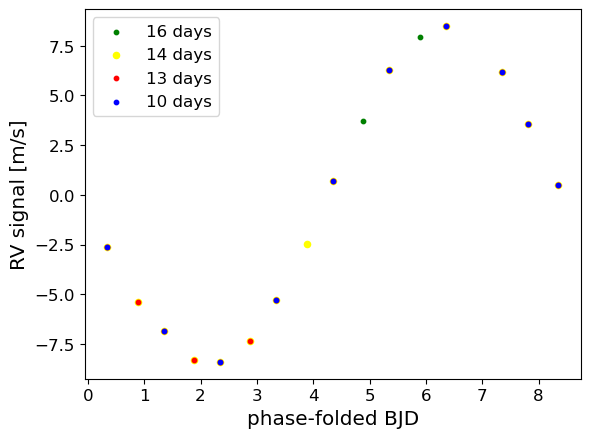

In [155]:
t_phase_folded_10 = strat[:10] % p # phase fold support
t_phase_folded_13 = strat[:13] % p # phase fold support
t_phase_folded_14 = strat[:14] % p # phase fold support
t_phase_folded_16 = strat[:16] % p # phase fold support

y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

#plt.scatter(strat[:10], y10)
#plt.scatter(strat[:13], y13)
plt.scatter((strat[:16]-T0) % p, y16, label='16 days', c='green', s=10)
plt.scatter((strat[:14]-T0) % p, y14, label='14 days', c='yellow', s=20)
plt.scatter((strat[:13]-T0) % p, y13, label='13 days', c='red', s=10)
plt.scatter((strat[:10]-T0) % p, y10, label='10 days', c='blue', s=10)
plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')

plt.legend()
plt.show()

When we phase fold as above, subsequent points in an evenly spaced strategy add less information when they sample far away from the minimum and maximum. 

Then we do the same below, but randomly sampling for the same number of days. We want to know why the wiggles still happen for these. 

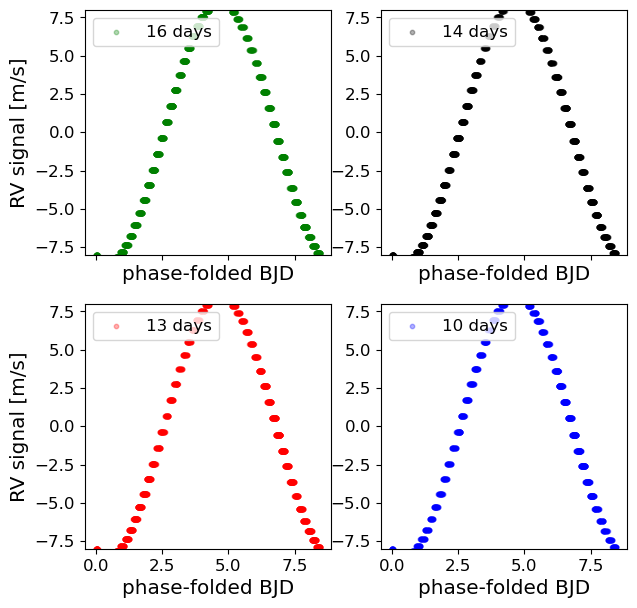

In [227]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7, 7), sharex=True)

t_phase_folded_10 = strat_subs[6][0] % p # phase fold support
t_phase_folded_13 = strat_subs[9][0] % p # phase fold support
t_phase_folded_14 = strat_subs[10][0] % p # phase fold support
t_phase_folded_16 = strat_subs[12][0] % p # phase fold support
    
y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
y16 = calculate_fi.model_jax(t_phase_folded_16, theta)
    
ax1.scatter(t_phase_folded_16, y16, label='16 days', c='green', s=10, alpha=0.3)
ax2.scatter(t_phase_folded_14, y14, label='14 days', c='k', s=10, alpha=0.3)
ax3.scatter(t_phase_folded_13, y13, label='13 days', c='red', s=10, alpha=0.3)
ax4.scatter(t_phase_folded_10, y10, label='10 days', c='blue', s=10, alpha=0.3)

for i in np.arange(199)+1:
    t_phase_folded_10 = strat_subs[6][i] % p # phase fold support
    t_phase_folded_13 = strat_subs[9][i] % p # phase fold support
    t_phase_folded_14 = strat_subs[10][i] % p # phase fold support
    t_phase_folded_16 = strat_subs[12][i] % p # phase fold support

    y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
    y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
    y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
    y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

    ax1.scatter(t_phase_folded_16, y16, c='green', s=10, alpha=0.3)
    ax2.scatter(t_phase_folded_14, y14, c='k', s=10, alpha=0.3)
    ax3.scatter(t_phase_folded_13, y13, c='red', s=10, alpha=0.3)
    ax4.scatter(t_phase_folded_10, y10, c='blue', s=10, alpha=0.3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

ax1.set_ylim([-8, 8])
ax2.set_ylim([-8, 8])
ax3.set_ylim([-8, 8])
ax4.set_ylim([-8, 8])

ax1.set_xlabel('phase-folded BJD')
ax2.set_xlabel('phase-folded BJD')
ax3.set_xlabel('phase-folded BJD')
ax4.set_xlabel('phase-folded BJD')

ax1.set_ylabel('RV signal [m/s]')
ax3.set_ylabel('RV signal [m/s]')

plt.show()

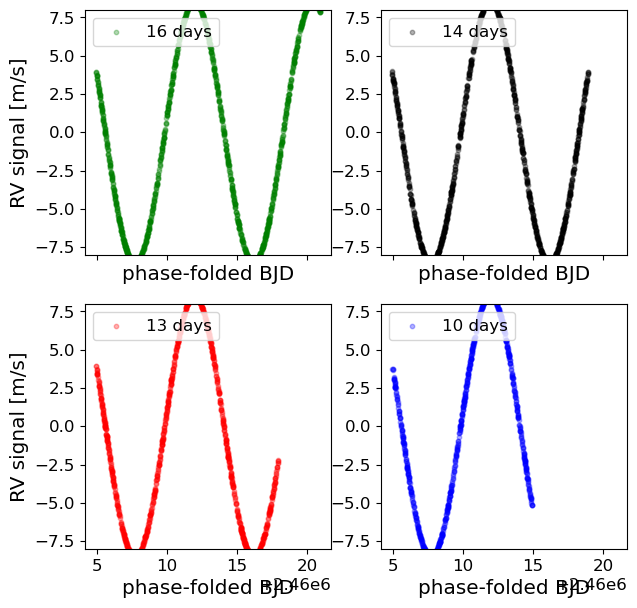

In [228]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7, 7), sharex=True)

t_phase_folded_10 = strat_subs[6][0] 
t_phase_folded_13 = strat_subs[9][0] 
t_phase_folded_14 = strat_subs[10][0] 
t_phase_folded_16 = strat_subs[12][0] 
  
y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
y16 = calculate_fi.model_jax(t_phase_folded_16, theta)
    
ax1.scatter(t_phase_folded_16, y16, label='16 days', c='green', s=10, alpha=0.3)
ax2.scatter(t_phase_folded_14, y14, label='14 days', c='k', s=10, alpha=0.3)
ax3.scatter(t_phase_folded_13, y13, label='13 days', c='red', s=10, alpha=0.3)
ax4.scatter(t_phase_folded_10, y10, label='10 days', c='blue', s=10, alpha=0.3)

for i in np.arange(99)+1:
    t_phase_folded_10 = strat_subs[6][i] 
    t_phase_folded_13 = strat_subs[9][i] 
    t_phase_folded_14 = strat_subs[10][i] 
    t_phase_folded_16 = strat_subs[12][i] 

    y10 = calculate_fi.model_jax(t_phase_folded_10, theta)
    y14 = calculate_fi.model_jax(t_phase_folded_14, theta)
    y13 = calculate_fi.model_jax(t_phase_folded_13, theta)
    y16 = calculate_fi.model_jax(t_phase_folded_16, theta)

    ax1.scatter(t_phase_folded_16, y16, c='green', s=10, alpha=0.3)
    ax2.scatter(t_phase_folded_14, y14, c='k', s=10, alpha=0.3)
    ax3.scatter(t_phase_folded_13, y13, c='red', s=10, alpha=0.3)
    ax4.scatter(t_phase_folded_10, y10, c='blue', s=10, alpha=0.3)

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')
ax3.legend(loc='upper left')
ax4.legend(loc='upper left')

ax1.set_ylim([-8, 8])
ax2.set_ylim([-8, 8])
ax3.set_ylim([-8, 8])
ax4.set_ylim([-8, 8])

ax1.set_xlabel('phase-folded BJD')
ax2.set_xlabel('phase-folded BJD')
ax3.set_xlabel('phase-folded BJD')
ax4.set_xlabel('phase-folded BJD')

ax1.set_ylabel('RV signal [m/s]')
ax3.set_ylabel('RV signal [m/s]')

plt.show()

The non-phase-folded plots show it better: when I go from 13 days (good) to 14 days ("bad", or rather, no improvement), I add points around the RV zero-point, so no new information has been contributed by the 14th observation. Remember! I'm not just adding random points along the phase curve willy-nilly. I'm only able to add random points within the next available 24 hours!

#### Correlated Noise Case

Finally, we declare the stellar noise parameters and populate the inputs for the covariance matrix and Fisher Information calculation functions.

In [246]:
### correlated noise parameters, from Klein+ 2021 for AU Mic
Prot = 4.86 # rotation period, days
Tau = 100/np.sqrt(2) # active region lifetime; days
eta = 0.4/np.sqrt(2) # 0.1, 0.3, 0.58, 0.9 # smoothing parameter
sigma_qp_rv = 47 # modified Jeffreys prior +11, -8 [m/s]
sigma_wn_rv = 5 # photon noise level [m/s]

params = [sigma_wn_rv, Tau, eta, Prot, sigma_qp_rv]
theta = [K, p, T0]

In [250]:
sigma_ks_qp = []
for i in tqdm(range(100)):
    sigma_ks_qp_temp = []
    # randomize start time/date
    start_random = random.uniform(start, start+p)
    
    for n_obs in range(60)[4:]:

        # instantiate Star object in order to feed covariance matrix with white/correlated noise
        star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv, Tau = Tau, eta = eta, 
                                 Prot = Prot, sigma_qp_rv = sigma_qp_rv)

        # populate list of parameters to feed into cov_matrix_jax()
        params = star.param_list()

        # instantiate Planets object in order to feed Fisher Info calculation machinery
        planet = calculate_fi.Planets(K = K, p = p, T0 = T0)

        # populate list of parameters to feed into clam_jax_fim()
        theta = planet.theta_list()

        # instantiate Strategy object in order to build time series of observations
        strategy = strategies.Strategy(n_obs = n_obs, start = start_random, offs=[], dropout=0.)

        # build strategy aka time series of observations
        strat = strategy.gappy(cadence)

        # build covariance matrix, characterized by a correlated noise model of the stellar signal
        kernel = kernels.ExpSineSquared(scale=Prot, gamma=1/(2*eta**2)) # first term of exponential
        kernel *= kernels.ExpSquared(scale=Tau) # other term of exponential
        kernel *= sigma_qp_rv**2 # multiply by scalar

        #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
        #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
        sigma = star.cov_matrix_general(strat, kernel) # object-oriented with custom kernels
        sigma += 1e-6 

        #print(strat, sigma)
        #fadsfa

        # populate arguments for Fisher Info calculator
        args = np.array(strat), sigma, jnp.array(theta, dtype=float)

        # calculate FI
        fim = calculate_fi.clam_jax_fim(*args).block_until_ready()

        # invert FI matrix
        inv_fim = inv(fim)

        # top left element of matrix corresponds with RV semi-amplitude, K
        sigma_k = np.sqrt(inv_fim)[0][0]

        sigma_ks_qp_temp.append(sigma_k)
    
    sigma_ks_qp.append(sigma_ks_qp_temp)


  0%|                                                                                                                   | 0/100 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2954/451925162.py:51: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:42<00:00,  1.62s/it]


#### Combine Plots for the Paper

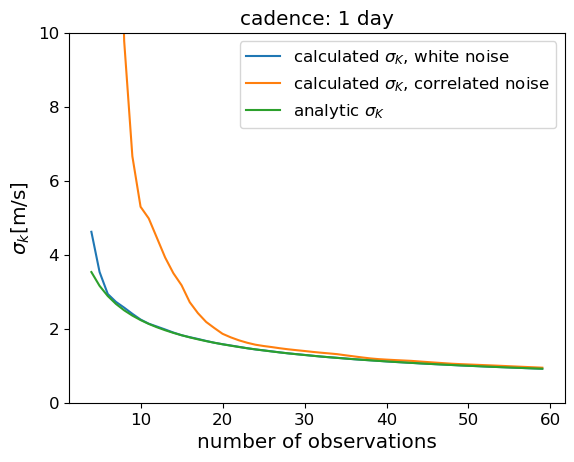

In [265]:
plt.plot(np.arange(len(sigma_ks[0]))+4, np.nanmean(sigma_ks, axis=0), label='calculated $\sigma_K$, white noise')
plt.plot(np.arange(len(sigma_ks_qp[0]))+4, np.nanmean(sigma_ks_qp, axis=0), label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks[0]))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks[0]))+4)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day")
plt.legend()
plt.ylim([0, 10])

#plt.vlines([4, 5], 0, 10, linestyle='--', color='red')
plt.savefig(path + f"plots/n_obs_meters.png", format="png")
plt.show()

In [46]:
Prot, p, cadence, star.sigma_qp_rv

(4.86, 8.46, 1, None)

Why are there bumps even in the white noise case? Find bumps and find out why they're there.

In [84]:
sigma_ks = []
n_obs = 4
periods = [p/2, p, 10.1, p*2]
sigma_ks1 = []
for i in tqdm(range(60)):
    
        
    # instantiate Star object in order to feed covariance matrix with white/correlated noise
    star = calculate_fi.Star(sigma_wn_rv = sigma_wn_rv)

    # populate list of parameters to feed into cov_matrix_jax()
    params = star.param_list()

    # instantiate Planets object in order to feed Fisher Info calculation machinery
    planet = calculate_fi.Planets(K = K, p = p/2, T0 = T0)

    # populate list of parameters to feed into clam_jax_fim()
    theta = planet.theta_list()

    # instantiate Strategy object in order to build time series of observations
    strategy = strategies.Strategy(n_obs = n_obs, start = start, offs=[], dropout=0.)

    # build strategy aka time series of observations
    #strat = strategy.gappy(cadence)
    strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

    #sigma = calculate_fi.cov_matrix_jax(strat, params) # non-object-oriented
    #sigma = star.cov_matrix(strat) # object-oriented but w/manual QP GP kernel
    sigma = star.cov_matrix_general(strat) # object-oriented with custom kernels
    sigma += 1e-6 

    # populate arguments for Fisher Info calculator
    args = np.array(strat), sigma, jnp.array(theta, dtype=float)

    # calculate FI
    fim = calculate_fi.clam_jax_fim(*args).block_until_ready()#[0][0]
    #sigma_k = 1/fim

    # invert FI matrix
    inv_fim = inv(fim)

    # top left element of matrix corresponds with RV semi-amplitude, K
    sigma_k = np.sqrt(inv_fim)[0][0]
    sigma_ks1.append(sigma_k)

    n_obs += 1


  0%|                                                                                                                    | 0/60 [00:00<?, ?it/s]/var/folders/fm/fpkllzw93kq7c5y3zl98167m0000gn/T/ipykernel_2954/4054728508.py:43: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 557.04it/s]


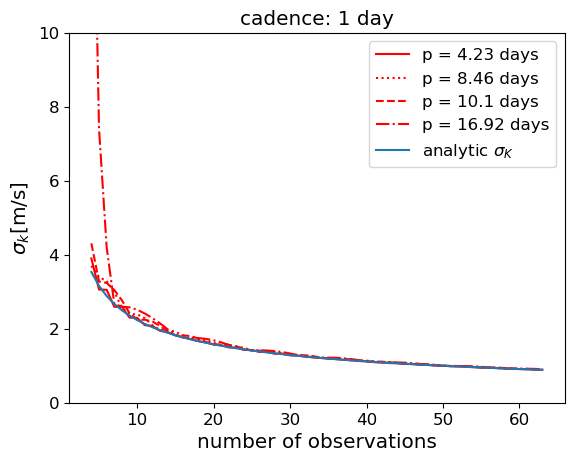

In [94]:
plt.plot(np.arange(len(sigma_ks1))+4, np.array(sigma_ks1), label='p = 4.23 days', color='red')
plt.plot(np.arange(len(sigma_ks2))+4, np.array(sigma_ks2), label='p = 8.46 days', linestyle='dotted', color='red')
plt.plot(np.arange(len(sigma_ks3))+4, np.array(sigma_ks3), label='p = 10.1 days', linestyle='--', color='red')
plt.plot(np.arange(len(sigma_ks4))+4, np.array(sigma_ks4), label='p = 16.92 days', linestyle='dashdot', color='red')

#plt.plot(np.arange(len(sigma_ks_qp))+4, np.array(sigma_ks_qp), label='calculated $\sigma_K$, correlated noise')
plt.plot(np.arange(len(sigma_ks4))+4, sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks4))+4)), label='analytic $\sigma_K$')
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.title(f"cadence: {cadence} day")
plt.legend()
plt.ylim([0, 10])

#plt.vlines([8, 14, 20], 0, 10, linestyle='--', color='red')
#plt.savefig(path + f"plots/n_obs_meters.png", format="png")
plt.show()

Why the bumps? Let's take the residuals and run them through a periodogram (suggestion by Lily Zhao). 

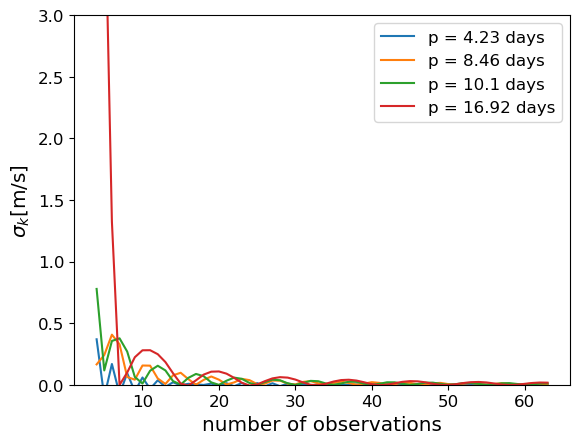

In [102]:
residual1 = np.array(sigma_ks1) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks1))+4))
residual2 = np.array(sigma_ks2) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks2))+4))
residual3 = np.array(sigma_ks3) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks3))+4))
residual4 = np.array(sigma_ks4) - sigma_wn_rv * np.sqrt(2/(np.arange(len(sigma_ks4))+4))
plt.plot(np.arange(len(sigma_ks1))+4, residual1, label='p = 4.23 days')
plt.plot(np.arange(len(sigma_ks2))+4, residual2, label='p = 8.46 days')
plt.plot(np.arange(len(sigma_ks3))+4, residual3, label='p = 10.1 days')
plt.plot(np.arange(len(sigma_ks4))+4, residual4, label='p = 16.92 days')
plt.ylim([0, 3])
plt.xlabel('number of observations')
plt.ylabel(r"$\sigma_k$[m/s]")
plt.legend()
plt.show()

In [100]:
from scipy.signal import find_peaks
print(find_peaks(residual1)[0] + 4)
print(find_peaks(residual2)[0] + 4)
print(find_peaks(residual3)[0] + 4)
print(find_peaks(residual4)[0] + 4)
print("")
print(np.median(np.diff(find_peaks(residual1)[0] + 4)))
print(np.median(np.diff(find_peaks(residual2)[0] + 4)))
print(np.median(np.diff(find_peaks(residual3)[0] + 4)))
print(np.median(np.diff(find_peaks(residual4)[0] + 4)))

[ 6  8 10 12 14 16 19 21 23 25 27 29 31 33 35 38 40 42 44 46 48 50 52 55
 57 59 61]
[ 6 10 15 19 23 27 32 36 40 44 49 53 57 61]
[ 7 12 17 22 27 32 37 42 48 53 58]
[11 20 28 37 45 54 62]

2.0
4.0
5.0
8.5


why does going from 13 to 14 observations, or from 9 to 10, increase sigma_K?

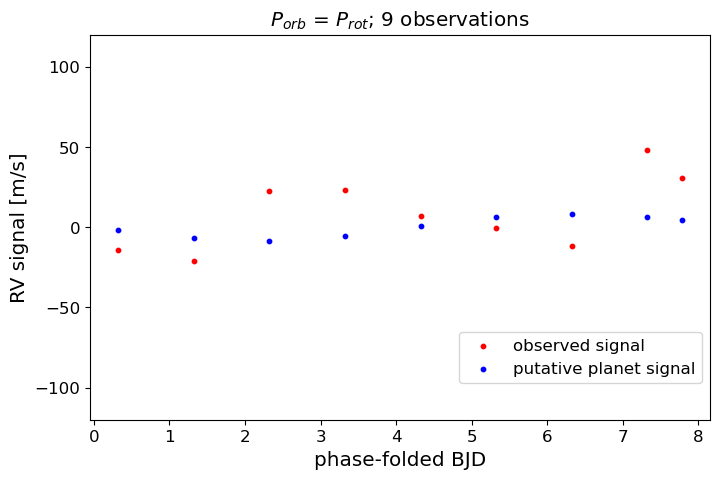

In [126]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)

# build strategy aka time series of observations
#strat = strategy.gappy(cadence)
strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))


plt.rcParams["figure.figsize"] = (8,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', c='red', s=10)
#plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
#            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', c='blue', s=10)
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title(r'$P_{orb}$ = $P_{rot}$; 9 observations')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/beat-freq1.pdf', format='pdf', bbox_inches='tight')
plt.show()

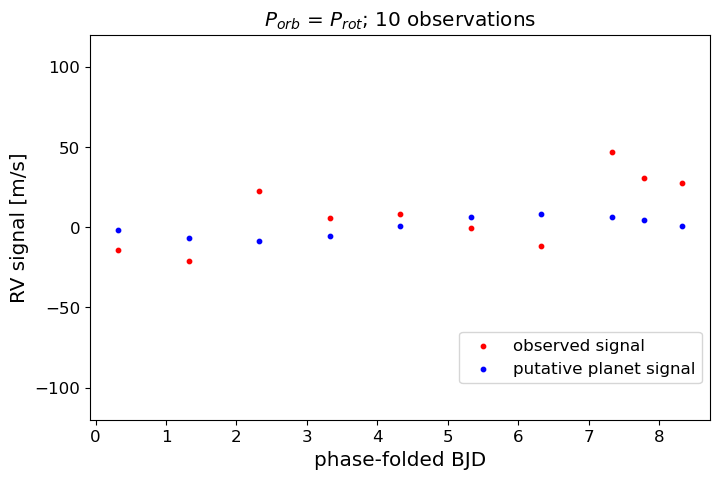

In [127]:
strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)

# build strategy aka time series of observations
#strat = strategy.gappy(cadence)
strat = strategy.on_vs_off(on=1, off=0, twice_flag=False)

t_phase_folded = strat % p # phase fold support
y_phase_folded = np.array(calculate_fi.model_jax(t_phase_folded, theta))

gp = GaussianProcess(kernel, strat)
sample = gp.sample(jax.random.PRNGKey(4), shape=(1,))

plt.rcParams["figure.figsize"] = (8,5)
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

from scipy.stats import binned_statistic

# first, create fiducial model of the planet signal
y = calculate_fi.model_jax(strat, theta)

# bin the observed signal of planet + stellar signal, phase-folded by orbital period
bins = 10
mean_stat_observed = binned_statistic((strat-T0) % p, sample + y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

# bin the observed signal of just the planet signal, phase-folded by orbital period
bins = 10
mean_stat_planet = binned_statistic((strat-T0) % p, y, 
                             statistic='mean', 
                             bins=bins, range=(0, p))

plt.scatter((strat-T0) % p, sample + y_phase_folded, label='observed signal', c='red', s=10)
#plt.scatter(mean_stat_observed.bin_edges[:-1], mean_stat_observed.statistic, label='binned observed signal', s=60, 
#            facecolors='none', edgecolors='r')
plt.scatter((strat-T0) % p, y_phase_folded, label='putative planet signal', c='blue', s=10)
#plt.scatter(mean_stat_planet.bin_edges[:-1], mean_stat_planet.statistic, label='binned planet signal', s=60, 
#            facecolors='none', edgecolors='blue')

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.title(r'$P_{orb}$ = $P_{rot}$; 10 observations')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
#plt.savefig(path + 'plots/beat-freq1.pdf', format='pdf', bbox_inches='tight')
plt.show()

How about not phase-folded?

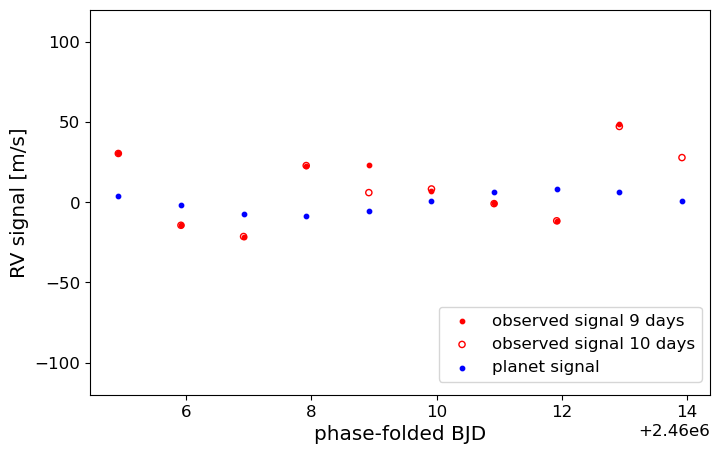

In [129]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)
strat1 = strategy.on_vs_off(on=1, off=0, twice_flag=False)
gp = GaussianProcess(kernel, strat1)
sample1 = gp.sample(jax.random.PRNGKey(4), shape=(1,))
y1 = calculate_fi.model_jax(strat1, theta)

strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)
strat2 = strategy.on_vs_off(on=1, off=0, twice_flag=False)
gp = GaussianProcess(kernel, strat2)
sample2 = gp.sample(jax.random.PRNGKey(4), shape=(1,))
y2 = calculate_fi.model_jax(strat2, theta)

plt.scatter((strat1), sample1 + y1, label='observed signal 9 days', c='red', s=10)
plt.scatter((strat2), sample2 + y2, label='observed signal 10 days', s=20, facecolors='none', edgecolors='r')
plt.scatter((strat2), y2, label='planet signal', c='blue', s=10)

plt.xlabel('phase-folded BJD')
plt.ylabel('RV signal [m/s]')
plt.ylim([-120, 120])
plt.legend(bbox_to_anchor=(1.0, 0.25))
plt.show()

In [121]:
print(strat1)
print(strat2)

[2460005.03466115 2460006.03466115 2460007.03466115 2460008.03466115
 2460009.03466115 2460010.03466115 2460011.03466115 2460012.03466115
 2460013.03466115]
[2460004.90643052 2460005.90643052 2460006.90643052 2460007.90643052
 2460008.90643052 2460009.90643052 2460010.90643052 2460011.90643052
 2460012.90643052 2460013.90643052]


In [123]:
strategy = strategies.Strategy(n_obs = 9, start = start, offs=[], dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
print(strat)

strategy = strategies.Strategy(n_obs = 10, start = start, offs=[], dropout=0.)
strat = np.array(strategy.on_vs_off(on=1, off=0, twice_flag=False))
print(strat)

[2460004.91666667 2460005.91666667 2460006.91666667 2460007.91666667
 2460008.91666667 2460009.91666667 2460010.91666667 2460011.91666667
 2460012.91666667]
[2460004.91666667 2460005.91666667 2460006.91666667 2460007.91666667
 2460008.91666667 2460009.91666667 2460010.91666667 2460011.91666667
 2460012.91666667 2460013.91666667]
